In [8]:
import classes.card_db
import splits.split
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600
plt.rcParams.update({'axes.labelsize': 20})
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)


First, let's figure out the average numer of splits required to get all cards inked and gold.

In [27]:
# copied and manipulated from splits/split.py
# I know this could be more efficient (bad data structures, loops)
# feel free to optimize yourself 

# get cards
split_dict = {}
# need to make this better
cards = classes.card_db.cardDB(path='./data/')

total_splits = []
gold_split_nums = []
ink_split_nums = []
total_splits = []

# number of collections to simulate
# my computer takes about 3 minutes for 1000, so not going higher
# could likely cut down time by generating list of all possible splits
# and drawing from that set list without replacement
num_collections = 1000

# for every collection
for i in range(num_collections):
    # for every card in that collection
    for ind, card in cards.cards.iterrows():
        # intialize dict entry for card
        split_number = 0
        split_dict[card['cname']] = {}
        split_dict[card['cname']]['split_count'] = 0
        split_dict[card['cname']]['split_list'] = []
        split_dict[card['cname']]['gold_split_num'] = 0
        split_dict[card['cname']]['ink_split_num'] = 0

        # card is unsplit, so has no background and doesn't have ink or gold
        last_background = 'None'
        has_ink = False
        has_gold = False

        # begin splitting
        while not (has_ink and has_gold):
            # increase number of splits
            split_number += 1
            # split the card
            last_background, effect, color = splits.split.split_card(
                split_number=split_number)
            # check to see if the split exists for the card already
            # as duplicate splits are not allowed
            if ([last_background, effect, color] in
                    split_dict[card['cname']]['split_list']):
                # if the card has the split, we re-roll.
                # remove this split from the split count
                split_number -= 1
                # continue to next split
                continue

            # add split to the list of splits
            split_dict[card['cname']]['split_list'].append([last_background,
                                                            effect,
                                                            color])
            # if the most recent split is ink, flag it and
            # mark the split number (earliest ink split)
            if last_background == 'Ink' and not has_ink:
                has_ink = True
                split_dict[card['cname']]['ink_split_num'] = split_number
            # if the most recent split is gold, flag it and
            # mark the split number (earliest gold)
            if last_background == 'Gold' and not has_gold:
                has_gold = True
                split_dict[card['cname']]['gold_split_num'] = split_number
        # record the number of splits the card has had
        split_dict[card['cname']]['split_count'] = split_number

    temp_ink_split_nums = []
    temp_gold_split_nums = []
    temp_total_splits = 0
    for ind, card in cards.cards.iterrows():
        temp_ink_split_nums.append(split_dict[card['cname']]['ink_split_num'])
        temp_gold_split_nums.append(split_dict[card['cname']]['gold_split_num'])
        temp_total_splits += split_dict[card['cname']]['split_count']
    ink_split_nums.append(temp_ink_split_nums)
    gold_split_nums.append(temp_gold_split_nums)
    total_splits.append(temp_total_splits)
                           

Let's look at some summary statistics.

In [28]:
# First, convert to numpy arrays
ink_split_nums = np.array(ink_split_nums)
gold_split_nums = np.array(gold_split_nums)
max_split_nums  = np.maximum(ink_split_nums, gold_split_nums)

In [29]:
print(f'Median Inked, Gold, Both: {np.median(ink_split_nums):.2f} {np.median(gold_split_nums):.2f} {np.median(max_split_nums):.2f}')
print(f'Average Inked, Gold, Both: {np.average(ink_split_nums):.2f} {np.average(gold_split_nums):.2f} {np.average(max_split_nums):.2f}')
print('\n')
print(f'Quantile\tInk\tGold\tBoth')
for i in np.arange(1,11):
    if i != 10:
        print(f'{i*10}%\t\t{np.quantile(ink_split_nums,i/10):.2f}'
              f'\t{np.quantile(gold_split_nums,i/10):.2f}'
              f'\t{np.quantile(max_split_nums,i/10):.2f}')
    else:
        diff = 0.01
        print(f'{i*10-diff}%\t\t{np.quantile(ink_split_nums, i/10-diff):.2f}'
              f'\t{np.quantile(gold_split_nums, i/10-diff):.2f}'
              f'\t{np.quantile(max_split_nums, i/10-diff):.2f}')

Median Inked, Gold, Both: 10.00 10.00 14.00
Average Inked, Gold, Both: 11.48 12.40 15.90


Quantile	Ink	Gold	Both
10%		4.00	5.00	8.00
20%		6.00	6.00	10.00
30%		7.00	8.00	11.00
40%		8.00	9.00	13.00
50%		10.00	10.00	14.00
60%		11.00	12.00	16.00
70%		14.00	14.00	19.00
80%		17.00	17.00	22.00
90%		21.00	22.00	26.00
99.99%		34.00	35.00	38.00


Let's make a messy plot to get a feel for the data. We will use percentiles later to make it cleaner.

Text(0, 0.5, 'Number of Cards')

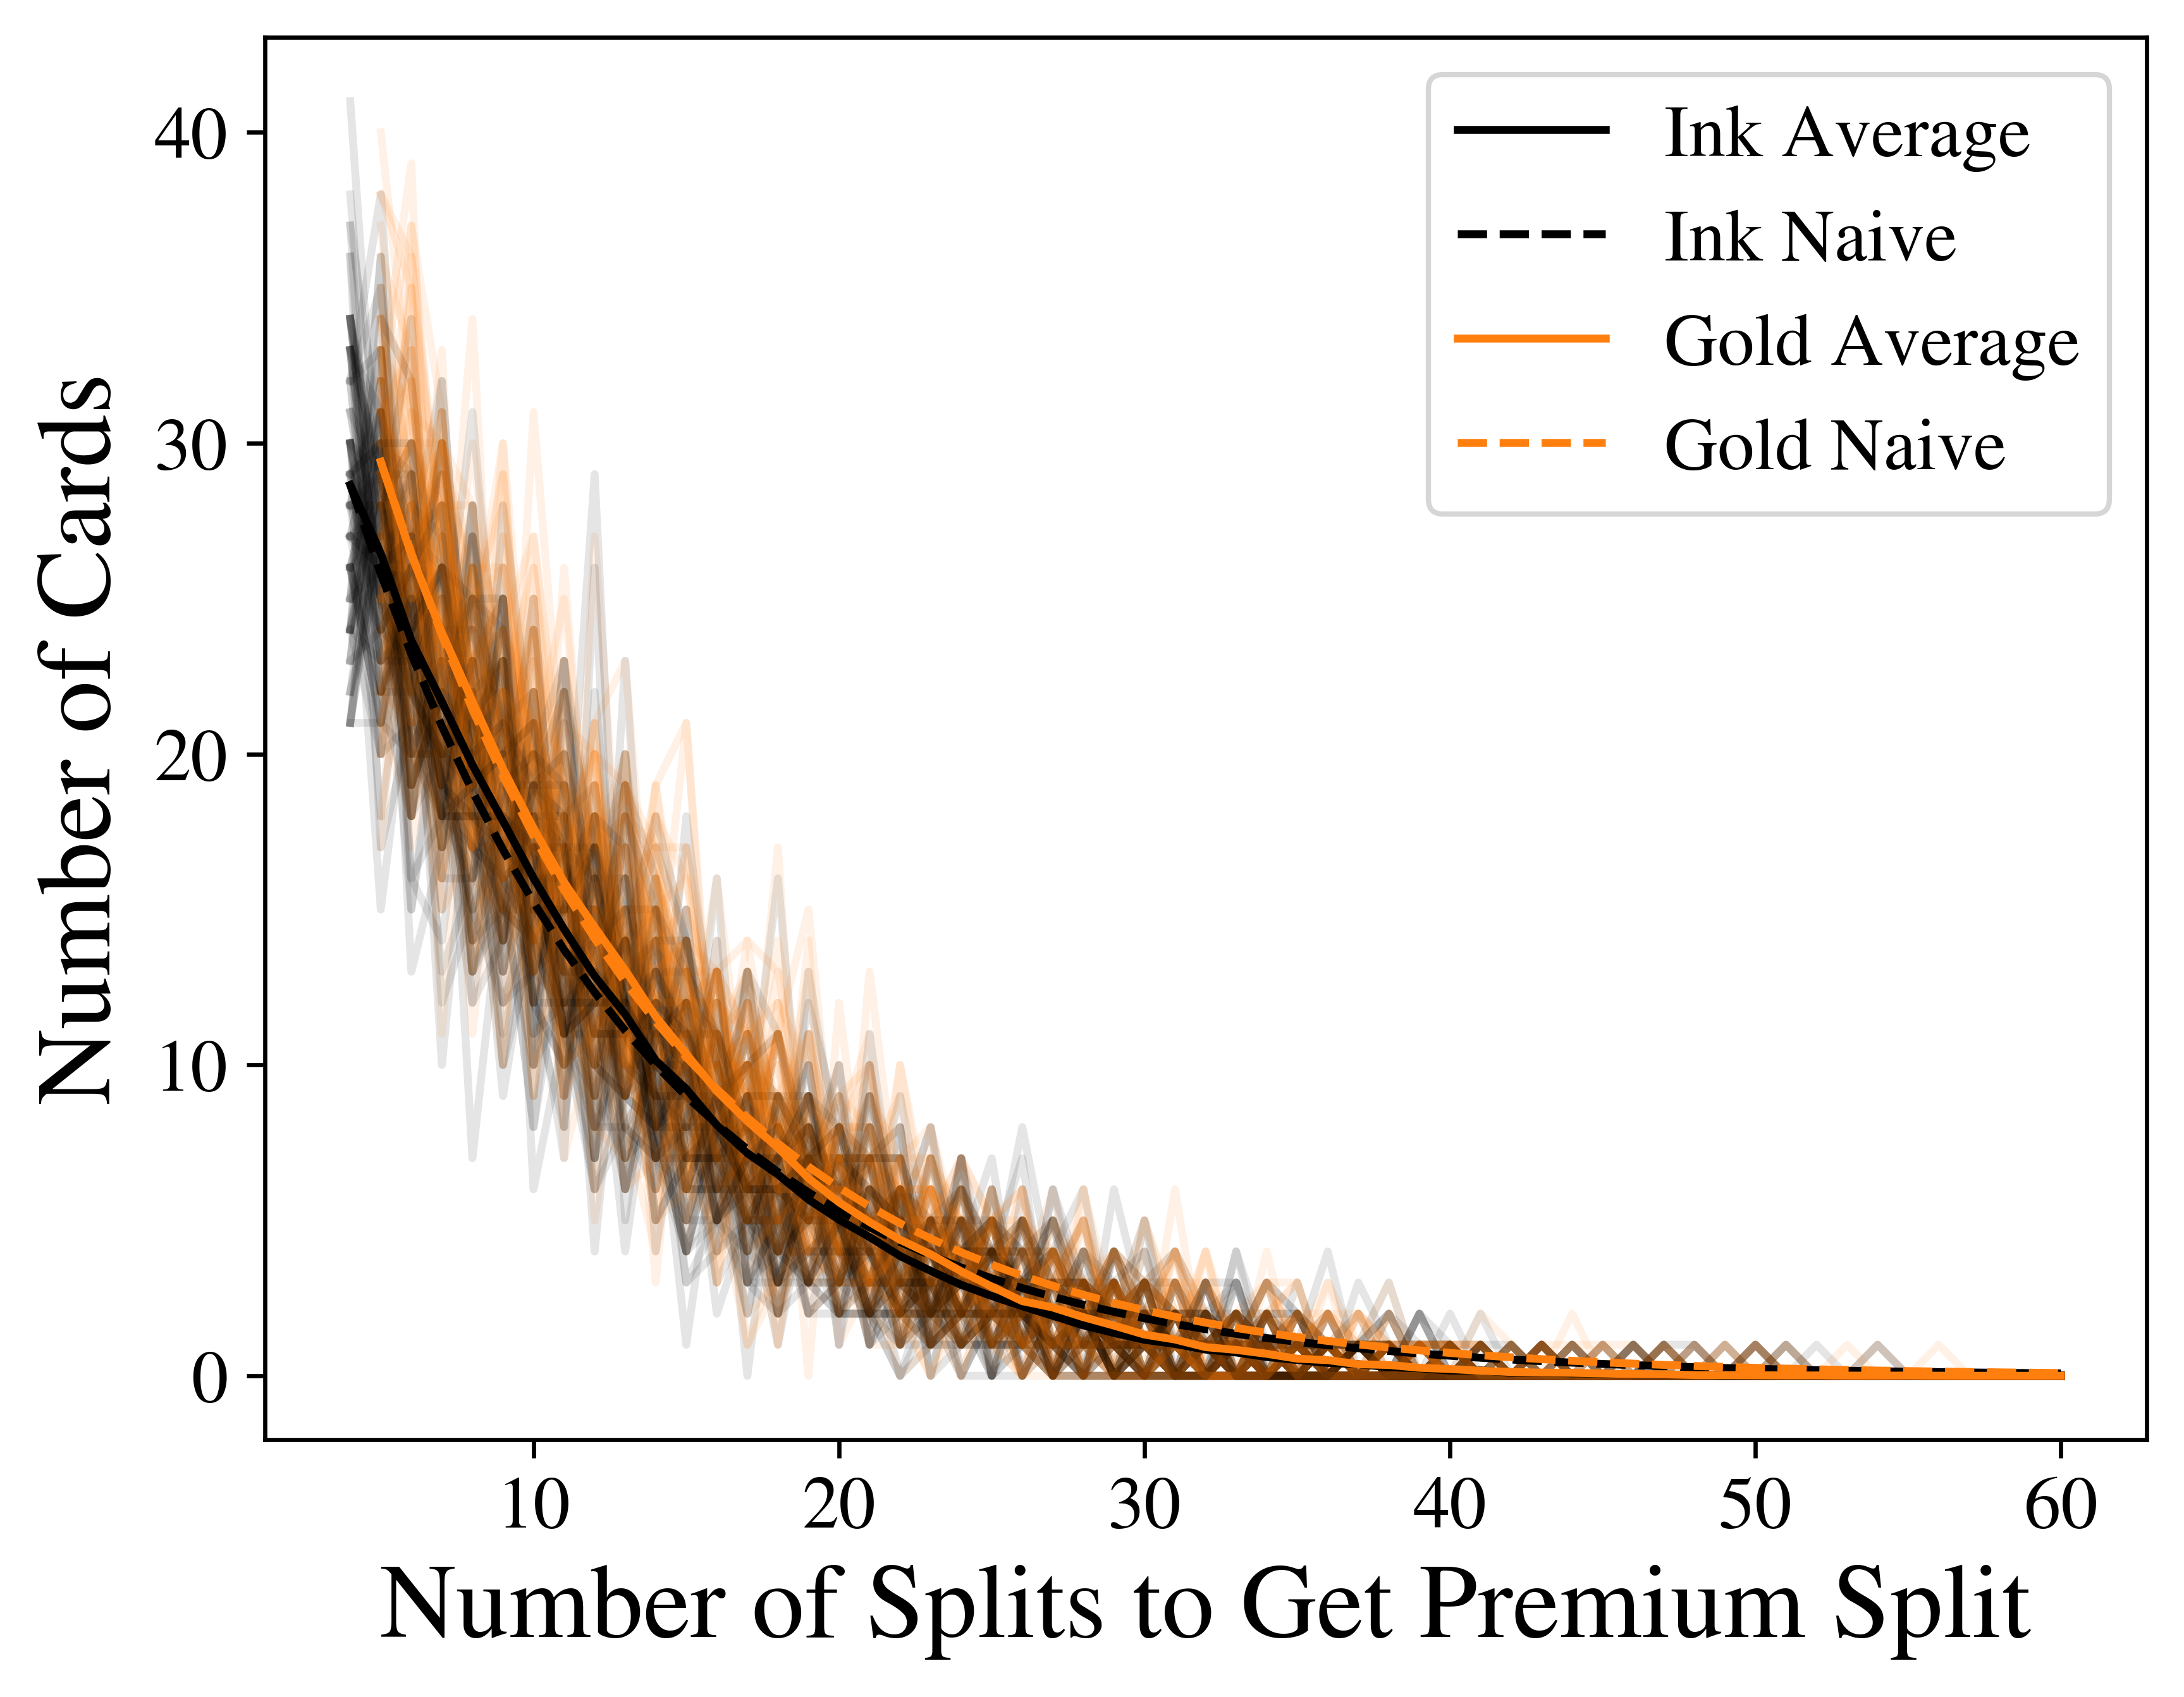

In [100]:
fig, ax = plt.subplots()
bin_min = 3.5
bin_max = 60.5
bins = np.linspace(bin_min, bin_max, int(1+bin_max-bin_min))
bin_centers = (bins[1:] + bins[:-1])/2

# only plot first 100 regardless of runsize to keep things clean
for i in range(100):
    # make histograms of the split numbers
    hist1, bins = np.histogram(ink_split_nums[i],bins=bins)
    ax.plot(bin_centers,hist1,'k',alpha=0.1)
    hist2, bins = np.histogram(gold_split_nums[i],bins=bins)
    ax.plot(bin_centers[1:],hist2[1:],'C1',alpha=0.1)

# I copied this from below, lazy but works
ink_hists = []
gold_hists = []

for i in range(num_collections):
    hist1, bins = np.histogram(ink_split_nums[i],bins=bins)
    ink_hists.append(hist1)
    hist2, bins = np.histogram(gold_split_nums[i],bins=bins)
    gold_hists.append(hist2)

ink_intercept = ink_split_nums.flatten()[ink_split_nums.flatten() == 4].shape[0]/num_collections
gold_intercept = gold_split_nums.flatten()[gold_split_nums.flatten() == 5].shape[0]/num_collections

ink_hist_average = np.average(ink_hists, axis=0)
gold_hist_average = np.average(gold_hists, axis=0)

ax.plot(bin_centers, ink_hist_average, color='k', label='Ink Average')
ax.plot(bin_centers, ink_intercept*( 0.9**(bin_centers-4)),'k--',label='Ink Naive')
ax.plot(bin_centers[1:], gold_hist_average[1:], color='C1', label='Gold Average')
ax.plot(bin_centers[1:], gold_intercept*( 0.9**(bin_centers-5))[1:],'C1--',label='Gold Naive')
ax.legend(fontsize=14)
ax.set_xlabel('Number of Splits to Get Premium Split')
ax.set_ylabel('Number of Cards')

Let's look at the impact of removing the possibility of duplicate splits.

Text(0, 0.5, 'Average Number of Cards')

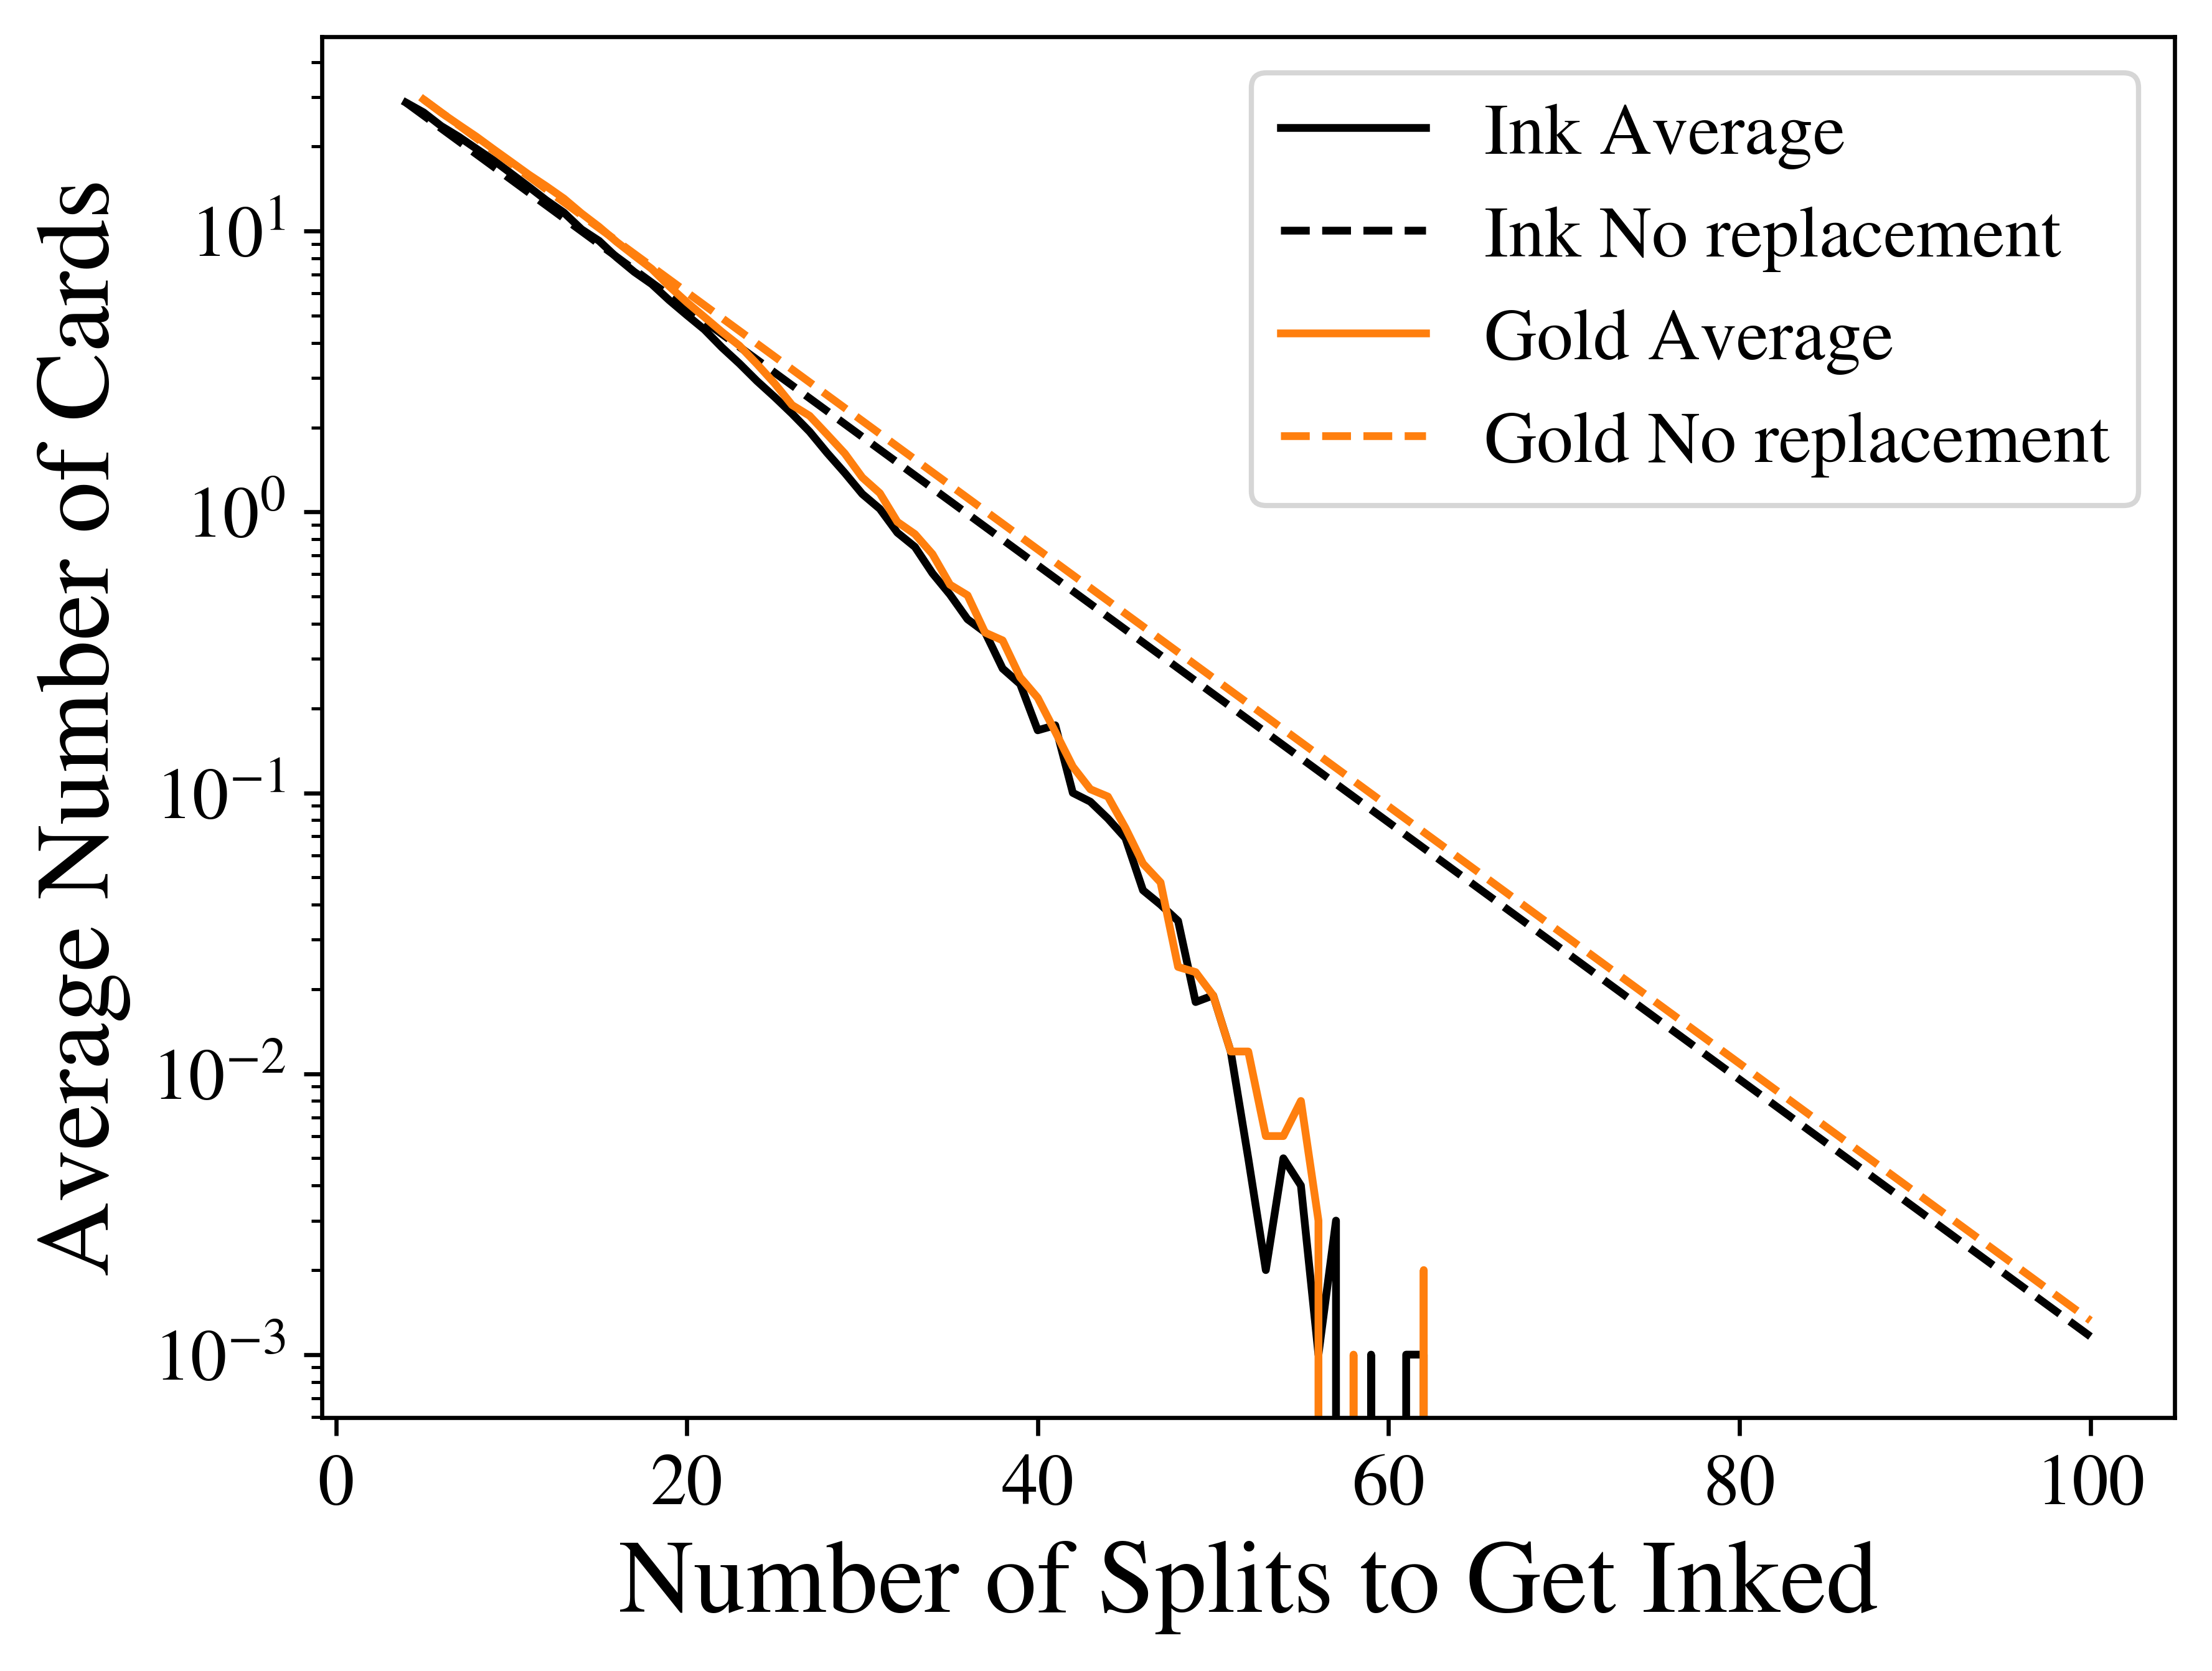

In [99]:
fig, ax = plt.subplots()
bin_min = 3.5
bin_max = 100.5
bins = np.linspace(bin_min, bin_max, int(1+bin_max-bin_min))
bin_centers = (bins[1:] + bins[:-1])/2

ink_hists = []
gold_hists = []
max_hists = []

for i in range(num_collections):
    hist1, bins = np.histogram(ink_split_nums[i],bins=bins)
    ink_hists.append(hist1)
    hist2, bins = np.histogram(gold_split_nums[i],bins=bins)
    gold_hists.append(hist2)
    hist3, bins = np.histogram(max_split_nums[i],bins=bins)
    max_hists.append(hist3)

ink_hists = np.array(ink_hists)
gold_hists = np.array(gold_hists)
max_hists = np.array(max_hists)

ink_hist_average = np.average(ink_hists, axis=0)
gold_hist_average = np.average(gold_hists, axis=0)
max_hist_average = np.average(max_hists, axis=0)

ink_hist_median = np.percentile(ink_hists, 50, axis=0)
gold_hist_median = np.percentile(gold_hists, 50, axis=0)
max_hist_median = np.percentile(max_hists, 50, axis=0)

ink_intercept = ink_split_nums.flatten()[ink_split_nums.flatten() == 4].shape[0]/num_collections
gold_intercept = gold_split_nums.flatten()[gold_split_nums.flatten() == 5].shape[0]/num_collections

ax.plot(bin_centers, ink_hist_average, color='k', label='Ink Average')
ax.plot(bin_centers, ink_intercept*( 0.9**(bin_centers-4)),color='k',linestyle='--', label='Ink No replacement')
ax.plot(bin_centers[1:], gold_hist_average[1:], color='C1', label='Gold Average')
ax.plot(bin_centers[1:], gold_intercept*( 0.9**(bin_centers-5))[1:], color='C1', linestyle='--', label='Gold No replacement')

plt.yscale('log')
plt.legend(loc=1, fontsize=14)
ax.set_xlabel('Number of Splits to Get Inked')
ax.set_ylabel('Average Number of Cards')

What does this look like in terms of Collection Level(CL)? We assume each split garners 31 CL. 

Quantile	3%	5%	32%	50%	68%	95%	97%
CL		34224	34224	59892	81204	111743	219318	291813
Base Cost	16836	16836	29463	39947	54970	107890	143553
Bundle Cost	11223	11223	19642	26631	36647	71927	95702
Max Cost	25392	25392	44436	60248	82906	162720	216506


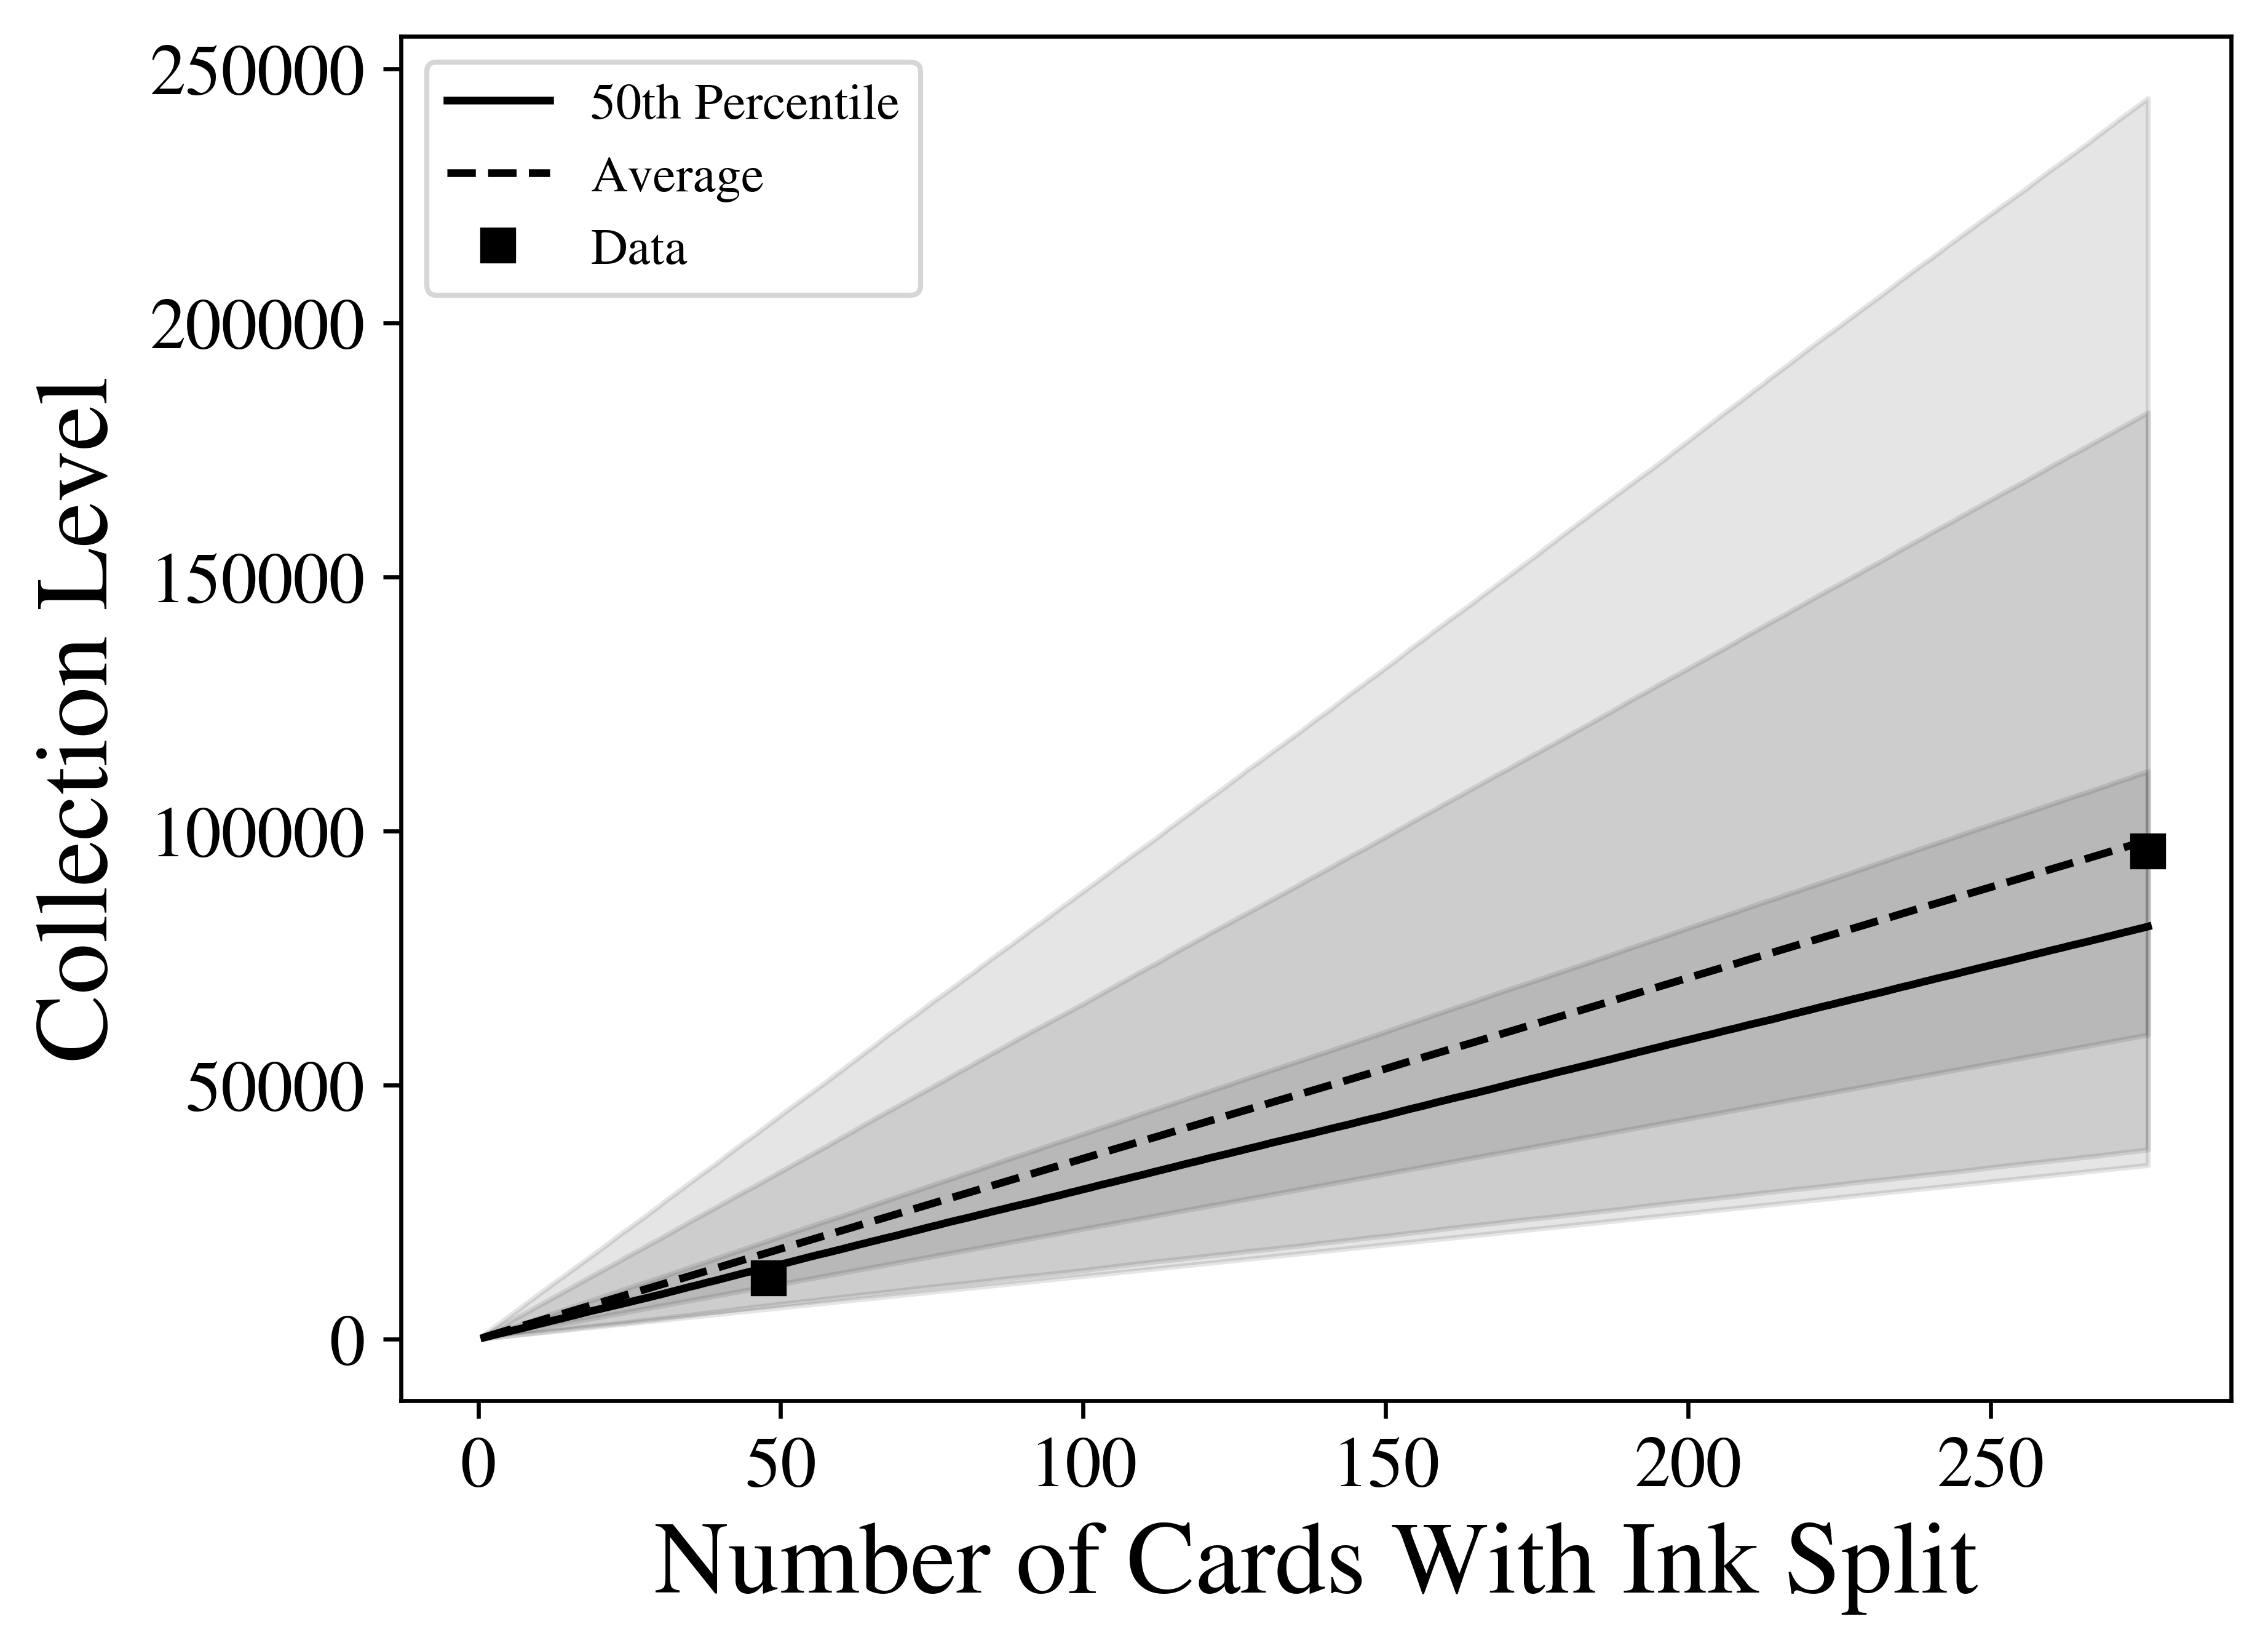

In [85]:
# plot for ink splits
percentiles = [[3,97], [10,90], [32,68]]

data = ink_split_nums

fig, ax = plt.subplots()

for perc in percentiles:
    ax.fill_between(np.arange(len(data[0]))+1, 
                    np.cumsum(31*np.percentile(data,perc[0],axis=0)),
                    np.cumsum(31*np.percentile(data,perc[1],axis=0)),
                    color='k', alpha=0.1)
ax.plot(np.arange(len(data[0]))+1, np.cumsum(31*np.percentile(data,50,axis=0)), color='k', label='50th Percentile')
ax.plot(np.arange(len(data[0]))+1, np.cumsum(31*np.average(data,axis=0)), color='k', label='Average',linestyle='--')

known_CLs = [12000,96000]
known_count = [48,len(data[0])]

plt.plot(known_count, known_CLs, 'ks', label='Data')
ax.legend(loc=2)
#ax.set_yscale('log')
ax.set_xlabel('Number of Cards With Ink Split')
ax.set_ylabel('Collection Level')

CL = [] 
base_cost = []
bundle_cost = []
max_cost = []
base_cost_per_split = 1525*400/500*100/8000
bundle_cost_per_split = 1525*50/7500  # from 'for you' bundles
max_cost_per_split = 1525*400/500*100/8000 + 155*4*100/8000
print('Quantile\t3%\t5%\t32%\t50%\t68%\t95%\t97%')
for perc in [3,5,32,50,68,95,99]:
    CL.append(np.cumsum(31*np.percentile(ink_split_nums,perc,axis=0))[-1])
    base_cost.append(np.cumsum(base_cost_per_split*np.percentile(data,perc,axis=0))[-1])
    bundle_cost.append(np.cumsum(bundle_cost_per_split*np.percentile(data,perc,axis=0))[-1])
    max_cost.append(np.cumsum(max_cost_per_split*np.percentile(data,perc,axis=0))[-1])
#CL = np.cumsum(31*np.percentile(ink_split_nums,[3,5,32,68,95,97],axis=0))[-1]
print(f'CL\t\t{int(CL[0]):d}\t{int(CL[1]):d}\t{int(CL[2]):d}\t{int(CL[3]):d}\t{int(CL[4]):d}\t{int(CL[5]):d}\t{int(CL[6]):d}')
print(f'Base Cost\t{int(base_cost[0]):d}\t{int(base_cost[1]):d}\t{int(base_cost[2]):d}\t{int(base_cost[3]):d}\t{int(base_cost[4]):d}\t{int(base_cost[5]):d}\t{int(base_cost[6]):d}')
print(f'Bundle Cost\t{int(bundle_cost[0]):d}\t{int(bundle_cost[1]):d}\t{int(bundle_cost[2]):d}\t{int(bundle_cost[3]):d}\t{int(bundle_cost[4]):d}\t{int(bundle_cost[5]):d}\t{int(bundle_cost[6]):d}')
print(f'Max Cost\t{int(max_cost[0]):d}\t{int(max_cost[1]):d}\t{int(max_cost[2]):d}\t{int(max_cost[3]):d}\t{int(max_cost[4]):d}\t{int(max_cost[5]):d}\t{int(max_cost[6]):d}')


Quantile	3%	5%	32%	50%	68%	95%	97%
CL		42780	42780	68407	89590	120040	225759	297144
Base Cost	21045	21045	33651	44072	59052	111058	146176
Bundle Cost	14030	14030	22434	29381	39368	74039	97450
Max Cost	31740	31740	50753	66470	89062	167498	220462


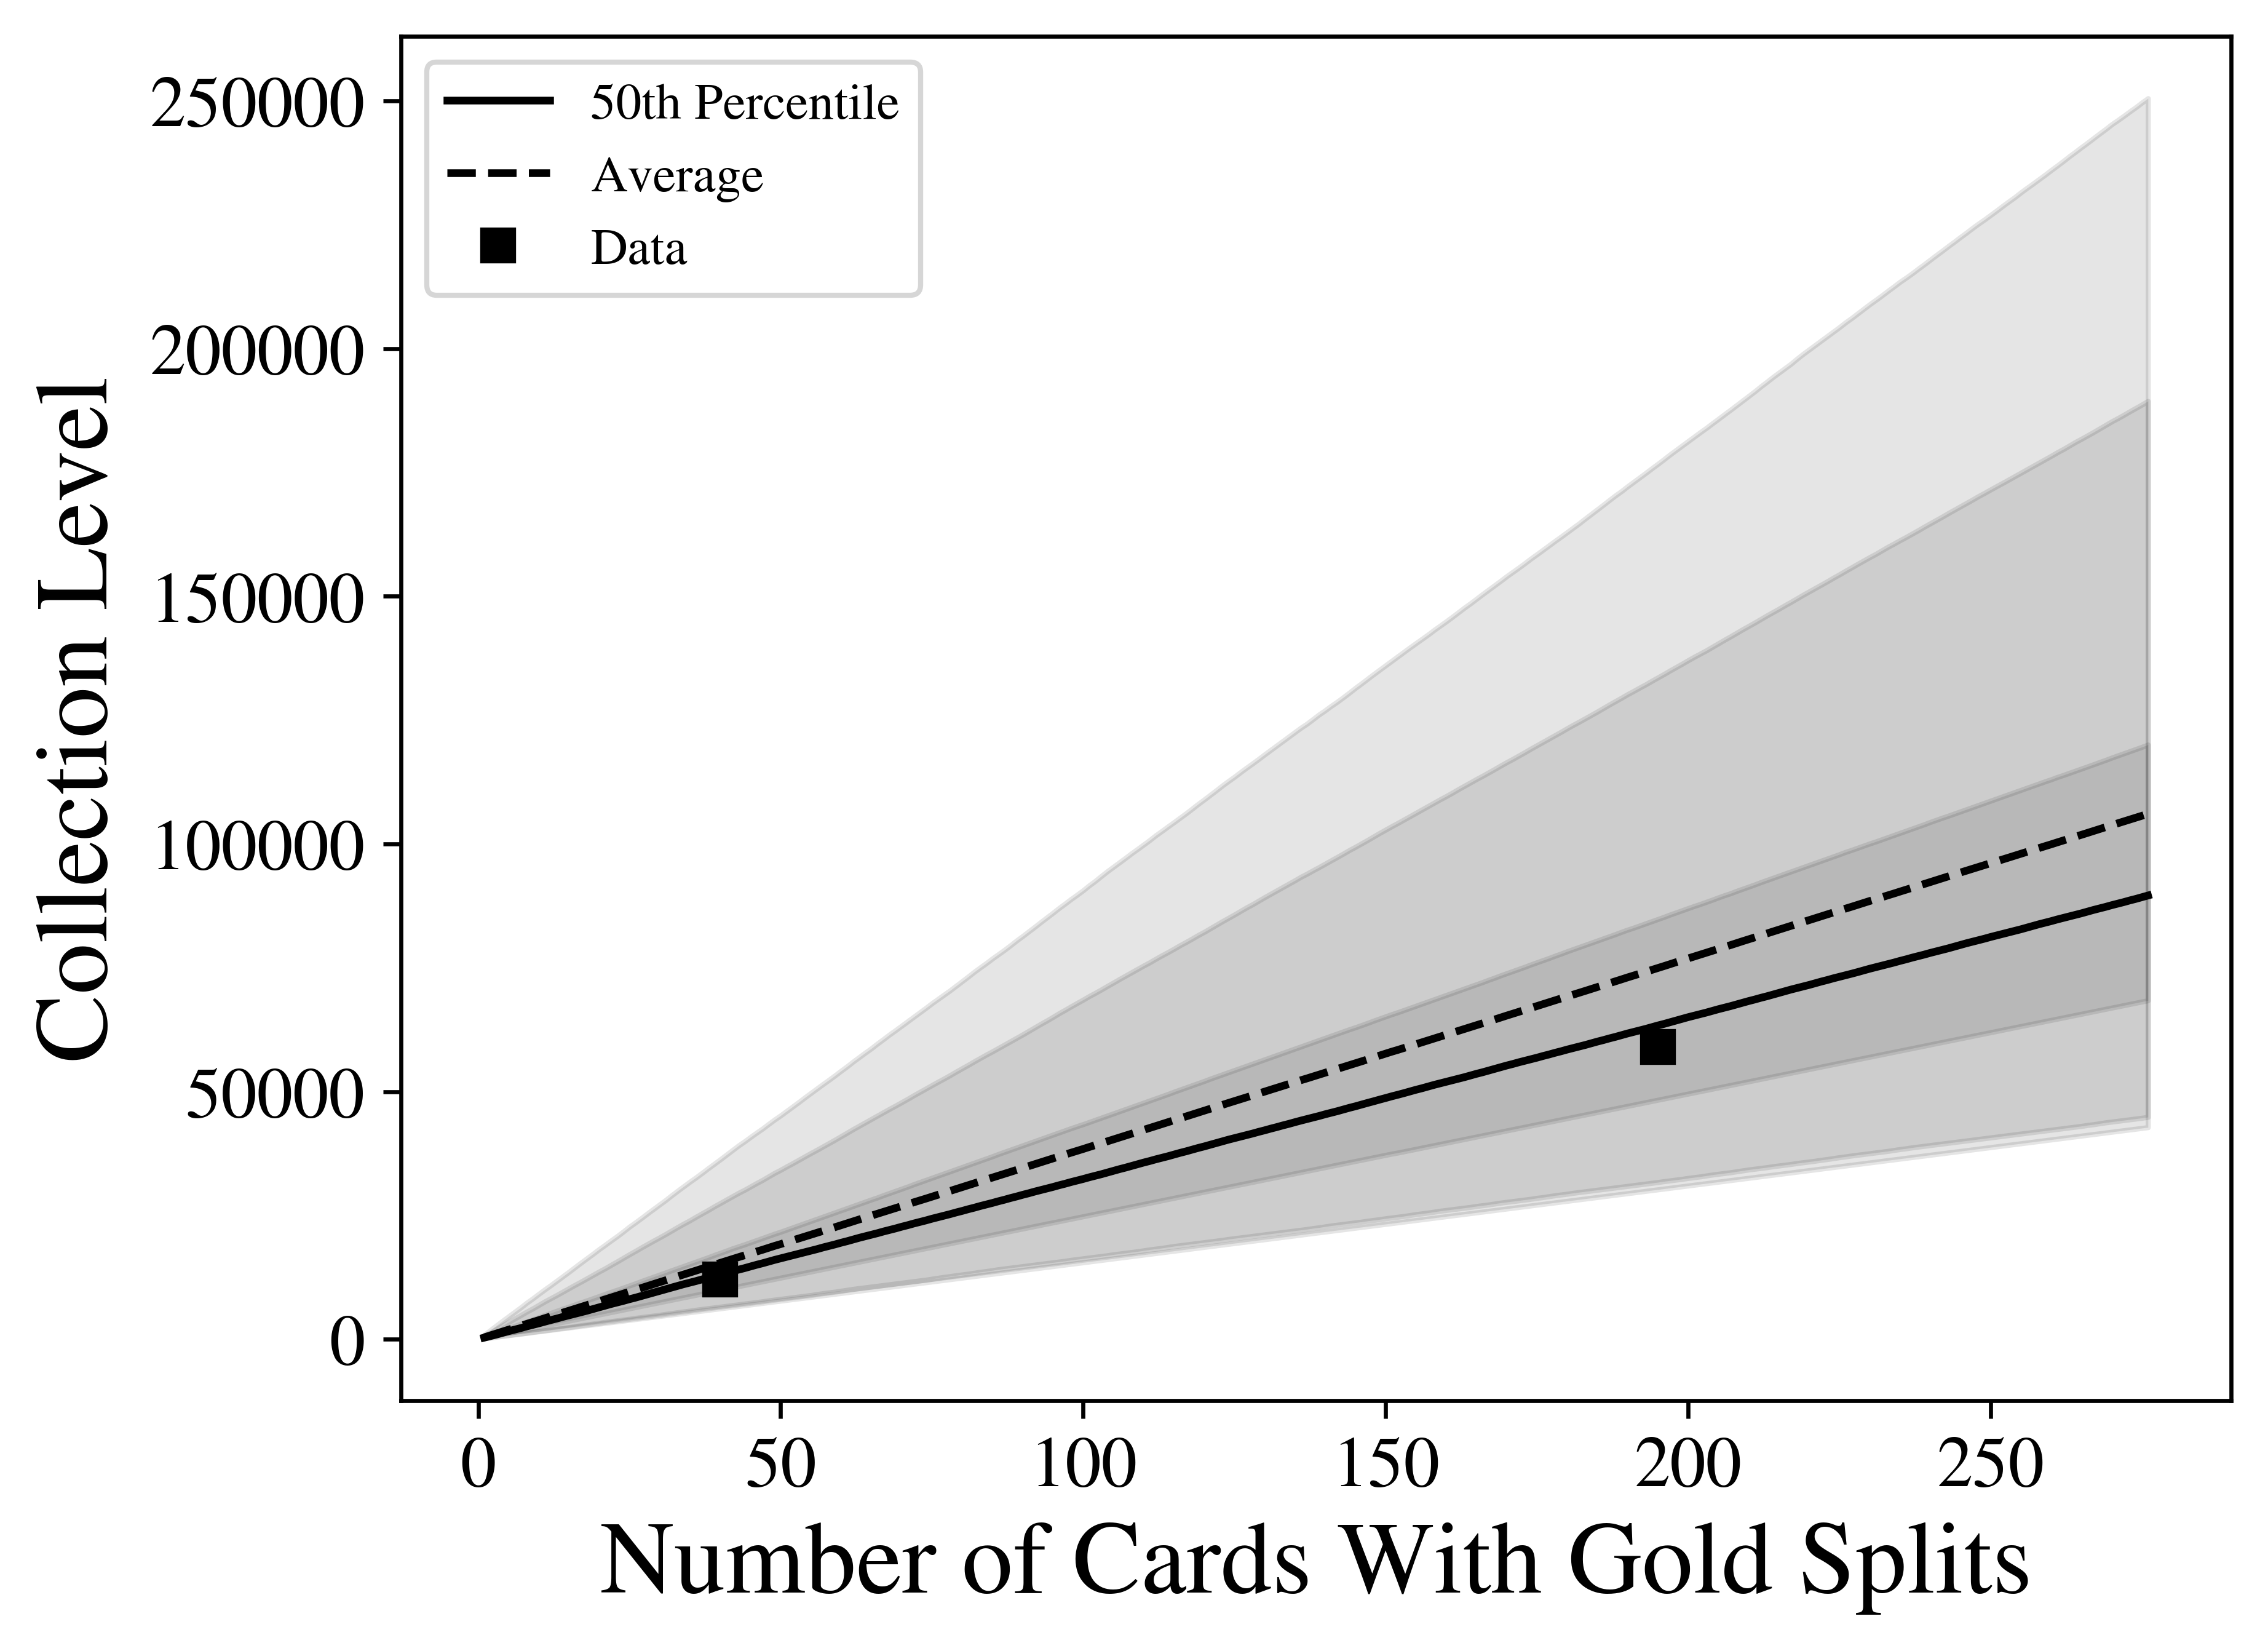

In [86]:
# plot for ink splits
percentiles = [[3,97], [10,90], [32,68]]

data = gold_split_nums

fig, ax = plt.subplots()

for perc in percentiles:
    ax.fill_between(np.arange(len(data[0]))+1, 
                    np.cumsum(31*np.percentile(data,perc[0],axis=0)),
                    np.cumsum(31*np.percentile(data,perc[1],axis=0)),
                    color='k', alpha=0.1)
ax.plot(np.arange(len(data[0]))+1, np.cumsum(31*np.percentile(data,50,axis=0)), color='k', label='50th Percentile')
ax.plot(np.arange(len(data[0]))+1, np.cumsum(31*np.average(data,axis=0)), color='k', label='Average',linestyle='--')

known_CLs = [12000,59000]
known_count = [40,195]

plt.plot(known_count, known_CLs, 'ks', label='Data')
ax.legend(loc=2)
#ax.set_yscale('log')
ax.set_xlabel('Number of Cards With Gold Splits')
ax.set_ylabel('Collection Level')

CL = [] 
base_cost = []
bundle_cost = []
max_cost = []
base_cost_per_split = 1525*400/500*100/8000
bundle_cost_per_split = 1525*50/7500  # from 'for you' bundles
max_cost_per_split = 1525*400/500*100/8000 + 155*4*100/8000
print('Quantile\t3%\t5%\t32%\t50%\t68%\t95%\t97%')
for perc in [3,5,32,50,68,95,99]:
    CL.append(np.cumsum(31*np.percentile(data,perc,axis=0))[-1])
    base_cost.append(np.cumsum(base_cost_per_split*np.percentile(data,perc,axis=0))[-1])
    bundle_cost.append(np.cumsum(bundle_cost_per_split*np.percentile(data,perc,axis=0))[-1])
    max_cost.append(np.cumsum(max_cost_per_split*np.percentile(data,perc,axis=0))[-1])
#CL = np.cumsum(31*np.percentile(ink_split_nums,[3,5,32,68,95,97],axis=0))[-1]
print(f'CL\t\t{int(CL[0]):d}\t{int(CL[1]):d}\t{int(CL[2]):d}\t{int(CL[3]):d}\t{int(CL[4]):d}\t{int(CL[5]):d}\t{int(CL[6]):d}')
print(f'Base Cost\t{int(base_cost[0]):d}\t{int(base_cost[1]):d}\t{int(base_cost[2]):d}\t{int(base_cost[3]):d}\t{int(base_cost[4]):d}\t{int(base_cost[5]):d}\t{int(base_cost[6]):d}')
print(f'Bundle Cost\t{int(bundle_cost[0]):d}\t{int(bundle_cost[1]):d}\t{int(bundle_cost[2]):d}\t{int(bundle_cost[3]):d}\t{int(bundle_cost[4]):d}\t{int(bundle_cost[5]):d}\t{int(bundle_cost[6]):d}')
print(f'Max Cost\t{int(max_cost[0]):d}\t{int(max_cost[1]):d}\t{int(max_cost[2]):d}\t{int(max_cost[3]):d}\t{int(max_cost[4]):d}\t{int(max_cost[5]):d}\t{int(max_cost[6]):d}')

Quantile	3%	5%	32%	50%	68%	95%	97%
CL		51673	59233	98345	123659	155453	255909	321816
Base Cost	25419	29138	48379	60832	76473	125891	158313
Bundle Cost	16946	19425	32253	40554	50982	83927	105542
Max Cost	38338	43947	72966	91747	115336	189868	238767


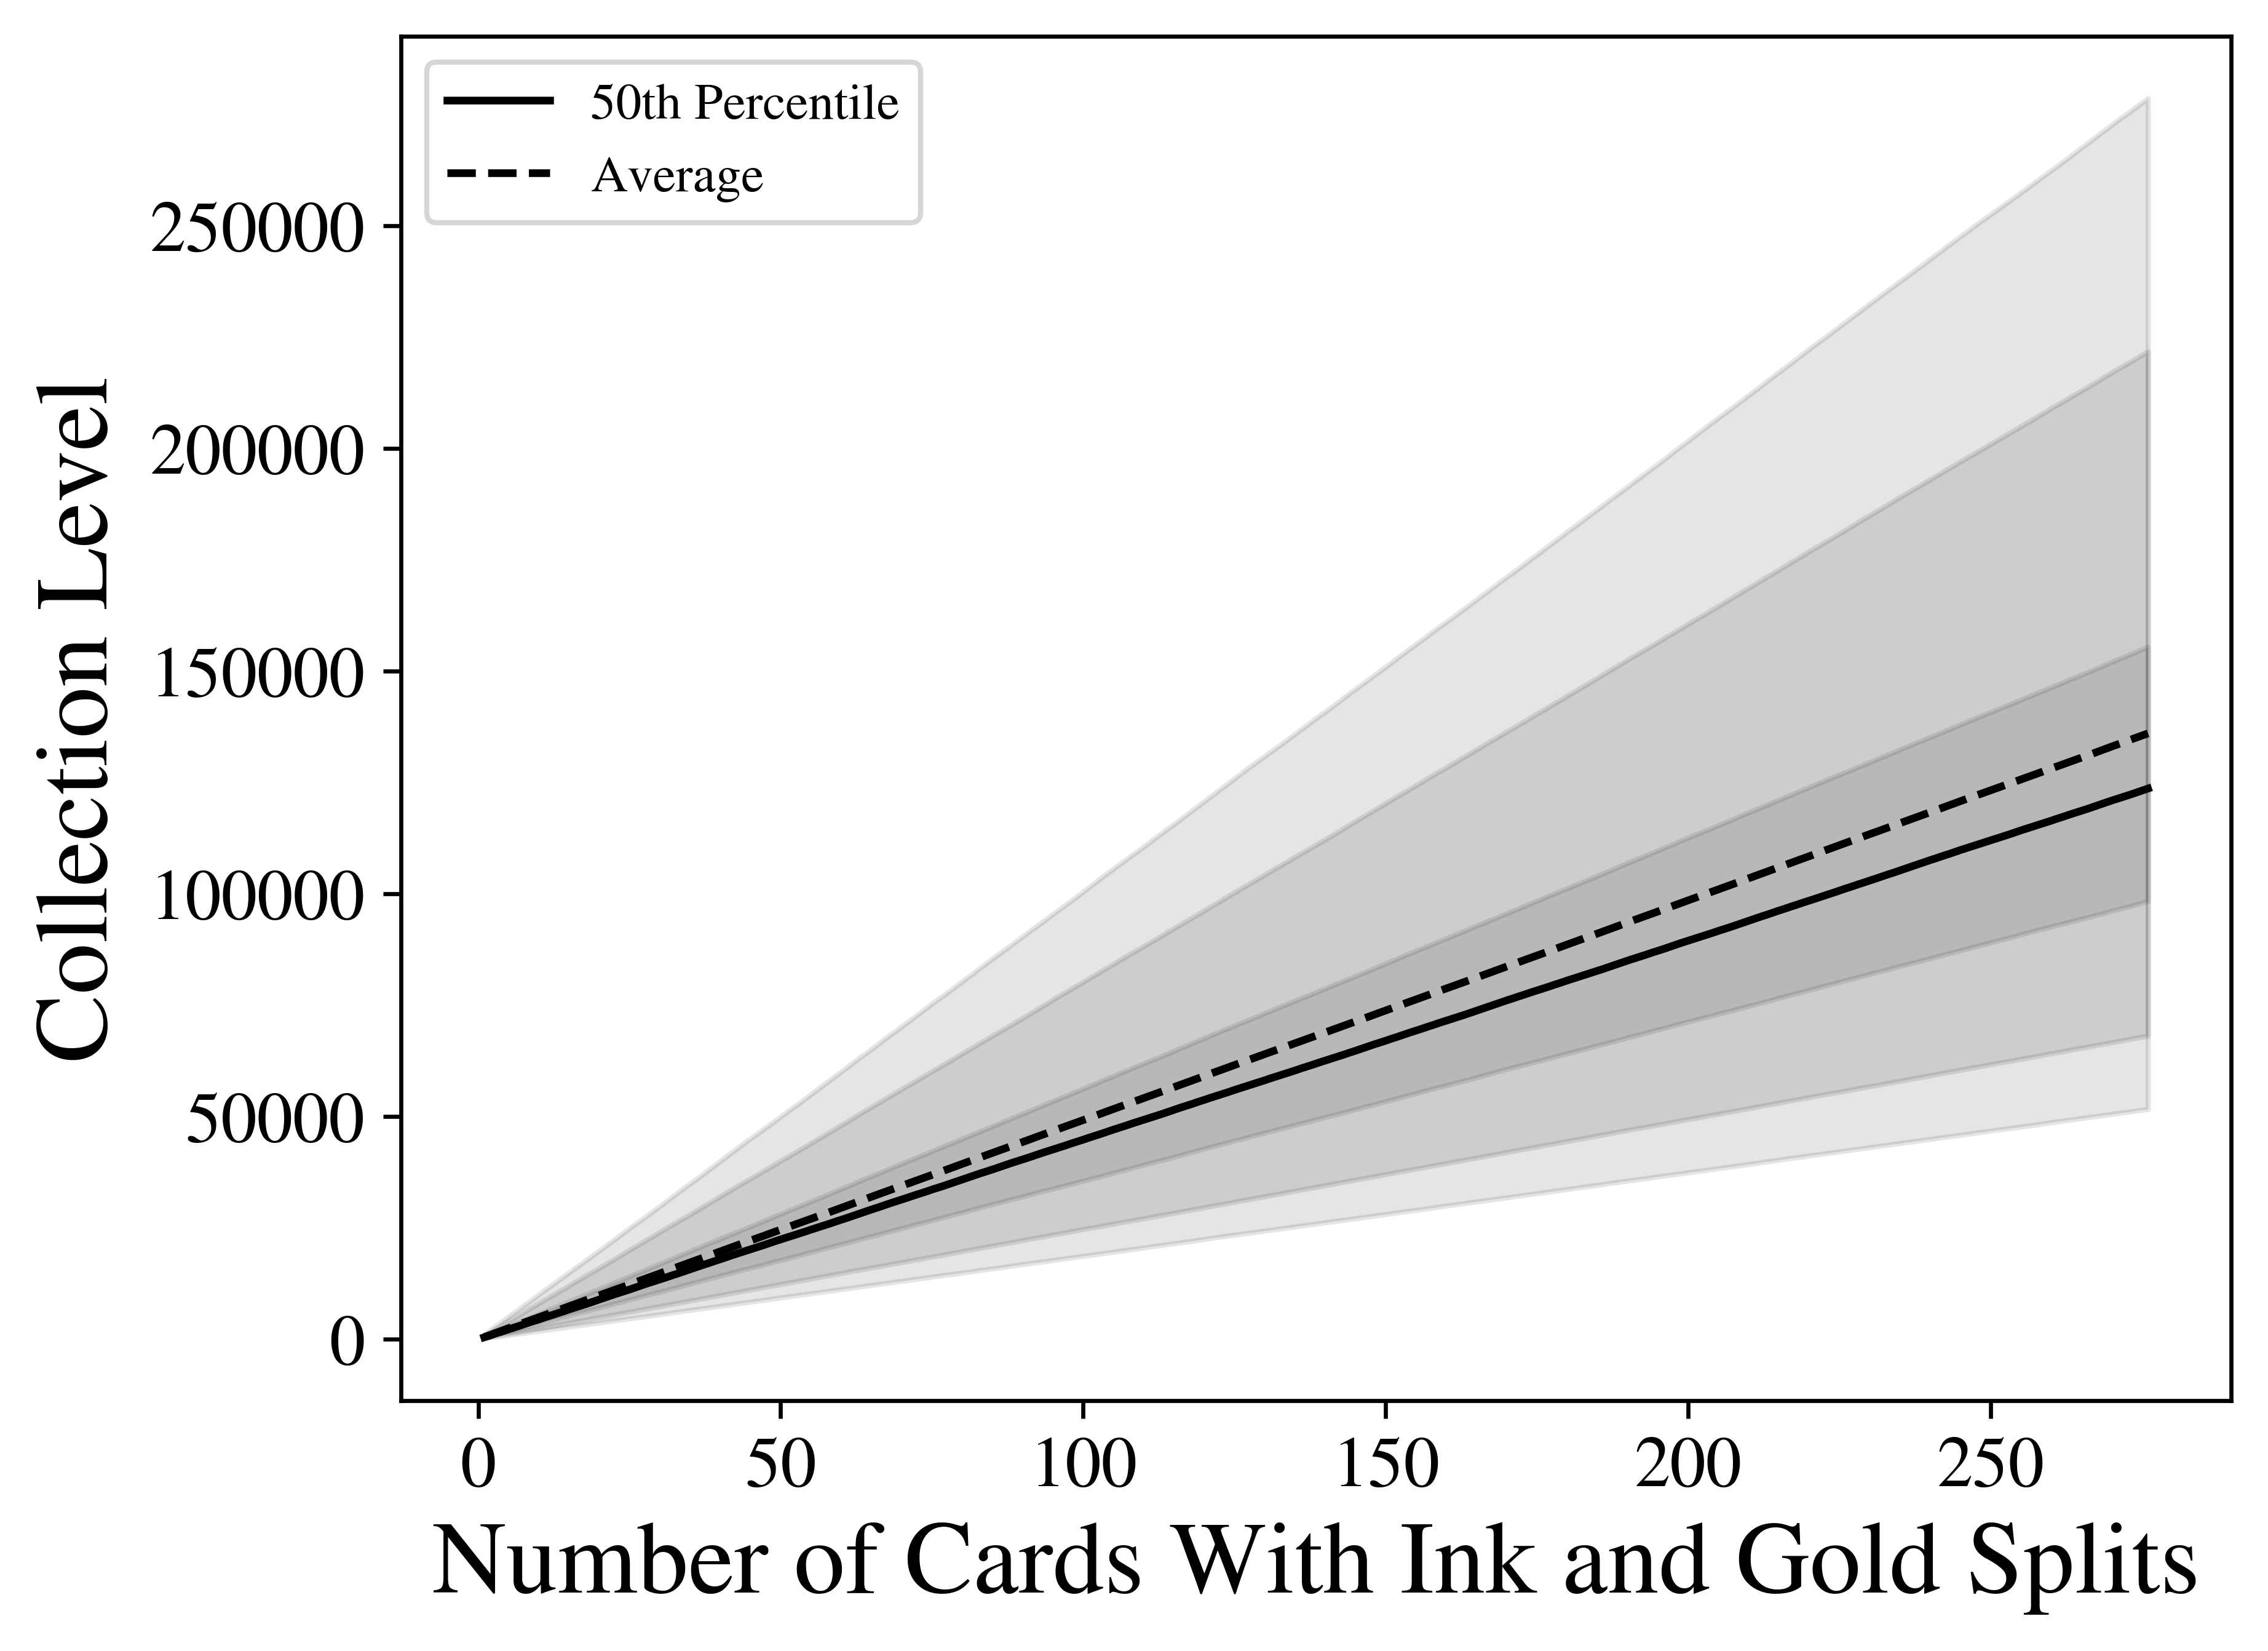

In [90]:
# plot for ink splits
percentiles = [[3,97], [10,90], [32,68]]

data = max_split_nums

fig, ax = plt.subplots()

for perc in percentiles:
    ax.fill_between(np.arange(len(data[0]))+1, 
                    np.cumsum(31*np.percentile(data,perc[0],axis=0)),
                    np.cumsum(31*np.percentile(data,perc[1],axis=0)),
                    color='k', alpha=0.1)
ax.plot(np.arange(len(data[0]))+1, np.cumsum(31*np.percentile(data,50,axis=0)), color='k', label='50th Percentile')
ax.plot(np.arange(len(data[0]))+1, np.cumsum(31*np.average(data,axis=0)), color='k', label='Average',linestyle='--')

ax.legend(loc=2)
#ax.set_yscale('log')
ax.set_xlabel('Number of Cards With Ink and Gold Splits')
ax.set_ylabel('Collection Level')

CL = [] 
base_cost = []
bundle_cost = []
max_cost = []
base_cost_per_split = 1525*400/500*100/8000
bundle_cost_per_split = 1525*50/7500  # from 'for you' bundles
max_cost_per_split = 1525*400/500*100/8000 + 155*4*100/8000
print('Quantile\t3%\t5%\t32%\t50%\t68%\t95%\t97%')
for perc in [3,5,32,50,68,95,99]:
    CL.append(np.cumsum(31*np.percentile(data,perc,axis=0))[-1])
    base_cost.append(np.cumsum(base_cost_per_split*np.percentile(data,perc,axis=0))[-1])
    bundle_cost.append(np.cumsum(bundle_cost_per_split*np.percentile(data,perc,axis=0))[-1])
    max_cost.append(np.cumsum(max_cost_per_split*np.percentile(data,perc,axis=0))[-1])
#CL = np.cumsum(31*np.percentile(ink_split_nums,[3,5,32,68,95,97],axis=0))[-1]
print(f'CL\t\t{int(CL[0]):d}\t{int(CL[1]):d}\t{int(CL[2]):d}\t{int(CL[3]):d}\t{int(CL[4]):d}\t{int(CL[5]):d}\t{int(CL[6]):d}')
print(f'Base Cost\t{int(base_cost[0]):d}\t{int(base_cost[1]):d}\t{int(base_cost[2]):d}\t{int(base_cost[3]):d}\t{int(base_cost[4]):d}\t{int(base_cost[5]):d}\t{int(base_cost[6]):d}')
print(f'Bundle Cost\t{int(bundle_cost[0]):d}\t{int(bundle_cost[1]):d}\t{int(bundle_cost[2]):d}\t{int(bundle_cost[3]):d}\t{int(bundle_cost[4]):d}\t{int(bundle_cost[5]):d}\t{int(bundle_cost[6]):d}')
print(f'Max Cost\t{int(max_cost[0]):d}\t{int(max_cost[1]):d}\t{int(max_cost[2]):d}\t{int(max_cost[3]):d}\t{int(max_cost[4]):d}\t{int(max_cost[5]):d}\t{int(max_cost[6]):d}')

TTD 
- make plots of expectations
- estimate costs